In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
import datetime as dt
import math

np.random.seed(0)
warnings.simplefilter("ignore")

# # # **Using EDA**

In [2]:
BASE_DIR = "/kaggle/input/learning-equality-curriculum-recommendations/"
content = pd.read_csv(BASE_DIR+"content.csv")
correlations = pd.read_csv(BASE_DIR+"correlations.csv")
topic = pd.read_csv(BASE_DIR+"topics.csv")
sub = pd.read_csv(BASE_DIR+"sample_submission.csv")

display(content.head())
display(topic.head())
display(correlations.head())
display(sub.head())

,id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA


,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True


,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_0008768bdee6,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4


,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_4054df11a74e,c_3695c5dc1df6 c_f2d184a98231


In [3]:
print("content shape:", content.shape)
print("topic shape:", topic.shape)
print("correlations shape:", correlations.shape)
print("sub shape:", sub.shape)

content shape: (154047, 8)
topic shape: (76972, 9)
correlations shape: (61517, 2)
sub shape: (5, 2)


In [4]:
content["license"] = content["license"].fillna("None")

In [5]:
print("content dublicated value sum:", content.duplicated().sum().sum())
print("topic dublicated value sum:", topic.duplicated().sum().sum())
print("correlations dublicated value sum:", correlations.duplicated().sum().sum())
print("sub dublicated value sum:", sub.duplicated().sum().sum())

content dublicated value sum: 0
topic dublicated value sum: 0
correlations dublicated value sum: 0
sub dublicated value sum: 0


In [6]:
def cat_cat_dist(data=None, feat1="", feat2="", feat1_lim="all", h=True, figsize=(16, 4), title="", title_fontsize=20, rotate=False, cut_xlabel=False):
    data_copy = data.copy()
    data_copy.loc[:, "count"] = 1
    if feat1_lim != "all":
        feat1_lim_value = data_copy[feat1].value_counts().index[:feat1_lim]
        data_copy = data_copy.loc[data_copy[feat1].isin(feat1_lim_value), :]
        if cut_xlabel:
            data_copy[feat1] = data_copy[feat1].str[:int((1/feat1_lim)*400)]
    data_copy = data_copy.groupby([feat1, feat2], as_index=False).agg({"count":"sum"})
    data_copy_div = data_copy.groupby([feat1], as_index=False).agg({"count":"sum"})
    data_copy_div.columns = [feat1, "div"]
    data_copy = data_copy.merge(data_copy_div, on=feat1)
    data_copy["normalized_count"] = data_copy["count"] / data_copy["div"] 
    data_copy.sort_values("count", inplace=True, ascending=False)
    if h:
        fig, axes = plt.subplots(2, figsize=figsize)
        fig.suptitle(title, fontsize=title_fontsize)
        sns.barplot(data=data_copy, x=feat1, y="count", hue=feat2, ax=axes[0])
        sns.barplot(data=data_copy, x=feat1, y="normalized_count", hue=feat2, ax=axes[1])
        if rotate:
            x_labels = data_copy[feat1].unique()
            axes[0].set_xticklabels(x_labels, rotation = 45)
            axes[1].set_xticklabels(x_labels, rotation = 45)
            fig.tight_layout()
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle(title, fontsize=title_fontsize)
        sns.barplot(data=data_copy, x=feat1, y="count", hue=feat2, ax=axes[0])
        sns.barplot(data=data_copy, x=feat1, y="normalized_count", hue=feat2, ax=axes[1])
        if rotate:
            x_labels = data_copy[feat1].unique()
            axes[0].set_xticklabels(x_labels, rotation = 45)
            axes[1].set_xticklabels(x_labels, rotation = 45)
            fig.tight_layout()

In [7]:
content_ids_df = pd.DataFrame()
content_ids = correlations["content_ids"].str.split(" ")
content_ids_df["topic_id"] = correlations["topic_id"].values
content_ids_df["content_ids"] = content_ids
content_ids_df["content_ids_len"] = content_ids.str.len()
content_ids_df = content_ids_df.merge(topic[["id", "has_content"]], left_on="topic_id", right_on="id")

content_ids_df.head()

,topic_id,content_ids,content_ids_len,id,has_content
0,t_00004da3a1b2,"[c_1108dd0c7a5d, c_376c5a8eb028, c_5bc0e1e2cba...",4,t_00004da3a1b2,True
1,t_00068291e9a4,"[c_639ea2ef9c95, c_89ce9367be10, c_ac1672cdcd2...",4,t_00068291e9a4,True
2,t_00069b63a70a,[c_11a1dc0bfb99],1,t_00069b63a70a,True
3,t_0006d41a73a8,"[c_0c6473c3480d, c_1c57a1316568, c_5e375cf14c4...",5,t_0006d41a73a8,True
4,t_0008768bdee6,"[c_34e1424229b4, c_7d1a964d66d5, c_aab93ee667f4]",3,t_0008768bdee6,True


In [8]:
content_ids_df.groupby("has_content").agg({"content_ids_len":["mean", "median"]})

content_ids_len       
                       mean median
has_content                       
True               4.550271    3.0

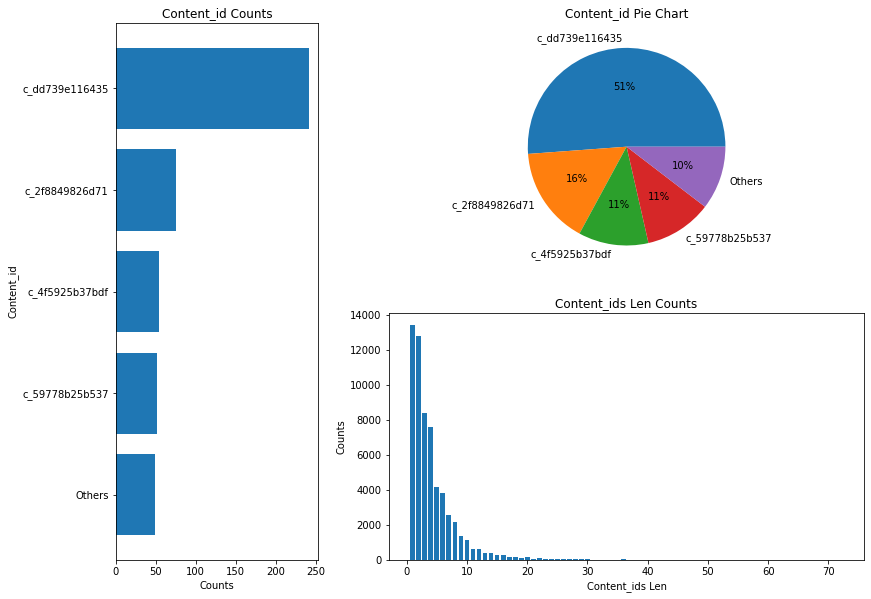

In [9]:
fig = plt.figure(figsize=(16, 12)) # initialize figure
axes = [None for _ in range(3)] # list to save many ax for setting parameter in each
axes[0] = plt.subplot2grid((3,4), (0,0), colspan=1, rowspan=2)
axes[1] = plt.subplot2grid((3,4), (0,1), colspan=2)
axes[2] = plt.subplot2grid((3,4), (1,1), colspan=2)

# Chart 0
content_dict = {content_id: 0 for content_id in content["id"]}
for index, row in content_ids_df.iterrows():
    for content_id in row["content_ids"]:
        content_dict[content_id]+=1

content_ids_count_series = pd.Series(content_dict)
content_ids_count_series.sort_values(inplace=True, ascending=False)

content_ids_count_df = content_ids_count_series.to_frame()
content_ids_count_df.reset_index(inplace=True)
content_ids_count_df.columns = ["content_id", "count"]

content_ids_count_df.loc[content_ids_count_df["count"]<=49, ["content_id", "count"]] = ["Others", 49]
content_ids_count_df.drop_duplicates(inplace=True)

axes[0].barh(content_ids_count_df["content_id"][::-1], content_ids_count_df["count"][::-1]);
axes[0].set_title("Content_id Counts")
axes[0].set_xlabel("Counts")
axes[0].set_ylabel("Content_id")

# Chart 1
axes[1].pie(content_ids_count_df["count"], labels = content_ids_count_df["content_id"],  autopct='%.0f%%');
axes[1].set_title("Content_id Pie Chart")

# Chart 2
content_ids_len_counts = content_ids_df["content_ids_len"].value_counts()[:50]
axes[2].bar(content_ids_len_counts.index, content_ids_len_counts.values)
axes[2].set_title("Content_ids Len Counts")
axes[2].set_xlabel("Content_ids Len")
axes[2].set_ylabel("Counts");

fig.tight_layout()


In [10]:
content.merge(content_ids_count_df, left_on="id", right_on="content_id")

,id,title,description,kind,text,language,copyright_holder,license,content_id,count
0,c_2f8849826d71,InfoPage,NaN,html5,This open text is disseminated via the Open Ed...,en,CSU and Merlot,CC BY-NC-SA,c_2f8849826d71,75
1,c_4f5925b37bdf,Index,NaN,html5,NaN,en,NaN,None,c_4f5925b37bdf,54
2,c_59778b25b537,Pasos siguientes,Descubra los pasos siguientes y recursos adici...,html5,Para recibir el certificado que necesita para ...,es,HP LIFE,CC BY,c_59778b25b537,52
3,c_dd739e116435,বই,NaN,document,NaN,bn,NaN,None,c_dd739e116435,241


In [11]:
def target_content_dist(feature="kind", ncols=3, h=False, figsize=(16,8)):
    feature_unique = content[feature].unique()
    feat_dict = {v: {v_inner:0 for v_inner in feature_unique} for v in feature_unique}
    
    content_id_map = content.set_index("id").to_dict()[feature]
    for index, row in content_ids_df.iterrows():
        row_values = []
        for content_id in row["content_ids"]:
            row_values.append(content_id_map[content_id])
        for v_uniq in set(row_values):
            for f_uniq in feature_unique:
                feat_dict[v_uniq][f_uniq] += row_values.count(f_uniq)
            feat_dict[v_uniq][v_uniq] -= 1
    
    nrows = int((len(feature_unique)+1) / ncols)
    if (len(feature_unique)+1) % ncols != 0:
        nrows += 1
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for index, ax in enumerate(axes.ravel()[:len(feature_unique)+1]):
        if h:
            if index==0:
                feature_count = content[feature].value_counts()
                ax.barh(feature_count.index, feature_count.values)
                ax.set_title(f"{feature} counts")
                ax.set_ylabel("count")
                ax.set_xlabel(feature)
            else:
                feat_name = feature_unique[index-1]
                ax.barh(list(feat_dict[feat_name].keys()), list(feat_dict[feat_name].values()))
                ax.set_title(feat_name)
                ax.set_ylabel("count")
                ax.set_xlabel(feature)
        else:
            if index==0:
                feature_count = content[feature].value_counts()
                ax.bar(feature_count.index, feature_count.values)
                ax.set_title(f"{feature} counts")
                ax.set_ylabel("count")
                ax.set_xlabel(feature)
            else:
                feat_name = feature_unique[index-1]
                ax.bar(feat_dict[feat_name].keys(), feat_dict[feat_name].values())
                ax.set_title(feat_name)
                ax.set_ylabel("count")
                ax.set_xlabel(feature)
    for ax in axes.ravel()[len(feature_unique)+1:]:
        ax.set_visible(False)
    fig.tight_layout()

In [12]:
def content_ids_len_analysis(feature_name="kind", ncols=3, figsize=(16,8)):
    from matplotlib.offsetbox import AnchoredText
    
    feature_unique = content[feature_name].unique()
    df_content_ids_analysis = pd.DataFrame()
    for index, row in content_ids_df.iterrows():
        feature_dict = {feature_id: 0 for feature_id in feature_unique}
        content_part = content.loc[content["id"].isin(row["content_ids"]), :]
        value_counts = content_part[feature_name].value_counts()
        for v in feature_unique:
            try:
                feature_dict[v] = value_counts[v]
            except:
                feature_dict[v] = 0
        df_content_ids_analysis = df_content_ids_analysis.append(feature_dict, ignore_index=True)
    df_content_ids_analysis["content_ids_len"] = content_ids_df["content_ids_len"].values
    
    nrows = int((len(feature_unique)+1) / ncols)
    if (len(feature_unique)+1) % ncols != 0:
        nrows += 1
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for index, (ax, feature) in enumerate(zip(axes.ravel()[:len(feature_unique)], feature_unique)):
        corr = df_content_ids_analysis[feature].corr(df_content_ids_analysis["content_ids_len"])
        scatter_kws = dict(
            alpha=0.75,
            s=3,
        )
        line_kws = dict(color='C3', )
        ax = sns.regplot(x=df_content_ids_analysis[feature],
                         y=df_content_ids_analysis["content_ids_len"],
                         scatter_kws=scatter_kws,
                         line_kws=line_kws,
                         lowess=True,
                         ax=ax)
        at = AnchoredText(
            f"{corr:.2f}",
            prop=dict(size="large"),
            frameon=True,
            loc="upper left",
        )
        at.patch.set_boxstyle("square, pad=0.0")
        ax.add_artist(at)
        
        ax.set_title(f"{feature} - content_ids_len scatter plot")
        ax.set_ylabel("content_ids_len")
        ax.set_xlabel(feature)
    for ax in axes.ravel()[len(feature_unique):]:
        ax.set_visible(False)
    fig.tight_layout()

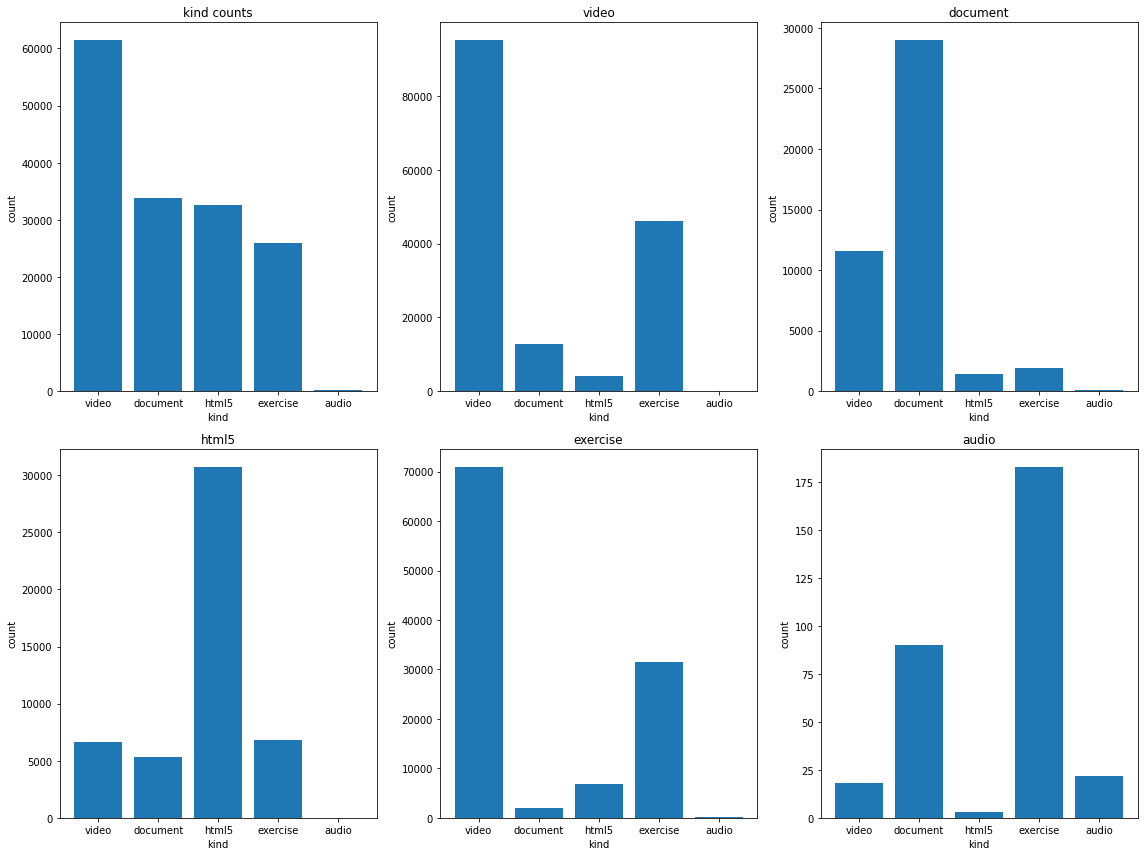

In [13]:
target_content_dist(feature="kind", ncols=3, figsize=(16,12))

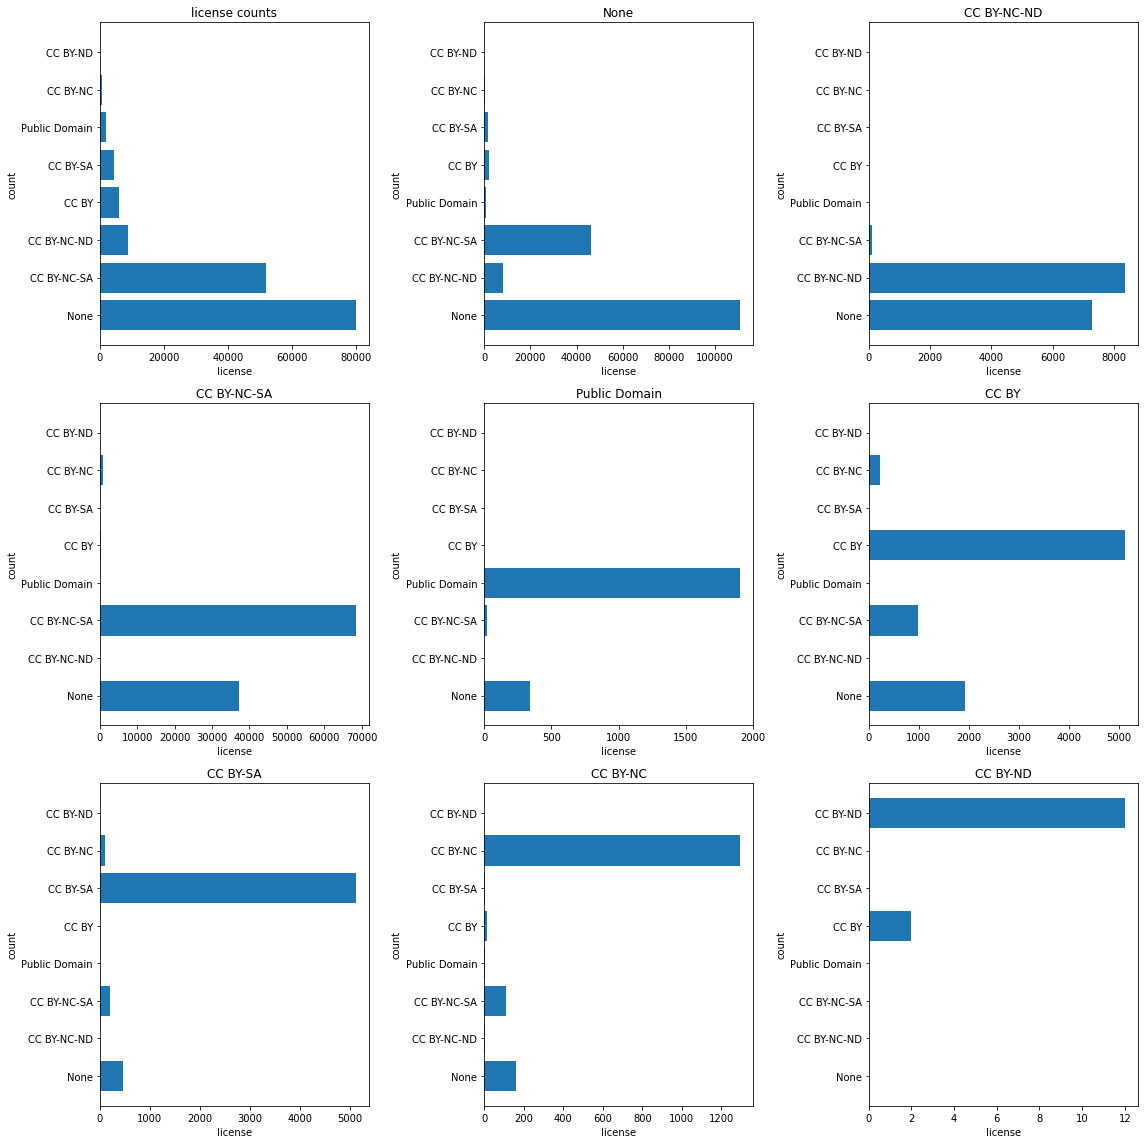

In [14]:
target_content_dist(feature="license", ncols=3, figsize=(16,16), h=True)

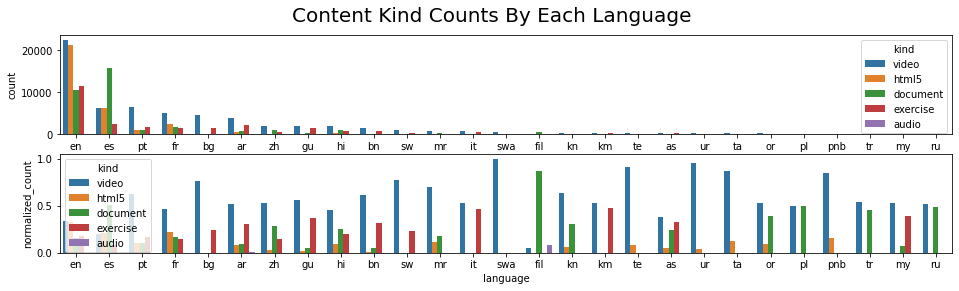

In [15]:
cat_cat_dist(data=content, feat1="language", feat2="kind", title="Content Kind Counts By Each Language")

In [16]:
licenses_details = {
    "Limitation": {0:"Credit must be given to the creator", 
                  1:"Adaptations must be shared under the same terms", 
                  2:"Only noncommercial uses of the work are permitted",
                  3:"No derivatives or adaptations of the work are permitted"},
    "CC BY": {0:True, 1:False, 2:False, 3:False},
    "CC BY-ND": {0:True, 1:False, 2:False, 3:True},
    "CC BY-SA": {0:True, 1:True, 2:False, 3:False},
    "CC BY-NC": {0:True, 1:False, 2:True, 3:False},
    "CC BY-NC-SA": {0:True, 1:True, 2:True, 3:False},
    "CC BY-NC-ND": {0:True, 1:False, 2:True, 3:True},
    "Public Domain": {0:False, 1:False, 2:False, 3:False}
}

df_licenses_def = pd.DataFrame(licenses_details)
df_licenses_def.set_index("Limitation", inplace=True)
df_licenses_def

,CC BY,CC BY-ND,CC BY-SA,CC BY-NC,CC BY-NC-SA,CC BY-NC-ND,Public Domain
Limitation,,,,,,,
Credit must be given to the creator,True,True,True,True,True,True,False
Adaptations must be shared under the same terms,False,False,True,False,True,False,False
Only noncommercial uses of the work are permitted,False,False,False,True,True,True,False
No derivatives or adaptations of the work are permitted,False,True,False,False,False,True,False


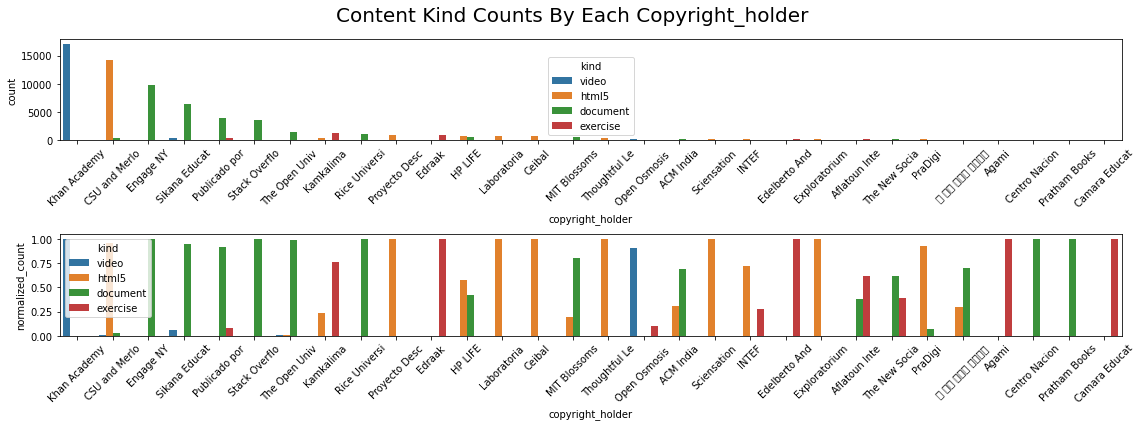

In [17]:
cat_cat_dist(data=content, feat1="copyright_holder", feat2="kind", title="Content Kind Counts By Each Copyright_holder", 
             feat1_lim=30, figsize=(16,6), rotate=True, cut_xlabel=True)

In [18]:
content["title_len"] = content["title"].str.len()
content["description_len"] = content["description"].str.len()
content["text_len"] = content["text"].str.len()

content[["title_len", "description_len", "text_len"]].describe()

,title_len,description_len,text_len
count,154038.000000,89456.000000,74035.000000
mean,33.829782,124.291249,10531.613440
std,18.106550,250.144003,18016.019783
min,1.000000,1.000000,1.000000
25%,21.000000,51.000000,1853.000000
50%,31.000000,82.000000,4486.000000
75%,44.000000,122.000000,10016.000000
max,177.000000,9710.000000,100000.000000


# # # **Model prepared**

In [19]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

SAMPLE_NUM = 1000
y_true = list(np.random.choice([0, 1], SAMPLE_NUM-2, p=[0.75, 0.25]))
y_true.extend([0, 1])
y_pred_zero = list(np.zeros(SAMPLE_NUM-2).astype(int))
y_pred_zero.extend([1, 1])
y_pred_one = list(np.ones(SAMPLE_NUM-2).astype(int))
y_pred_one.extend([0, 0])

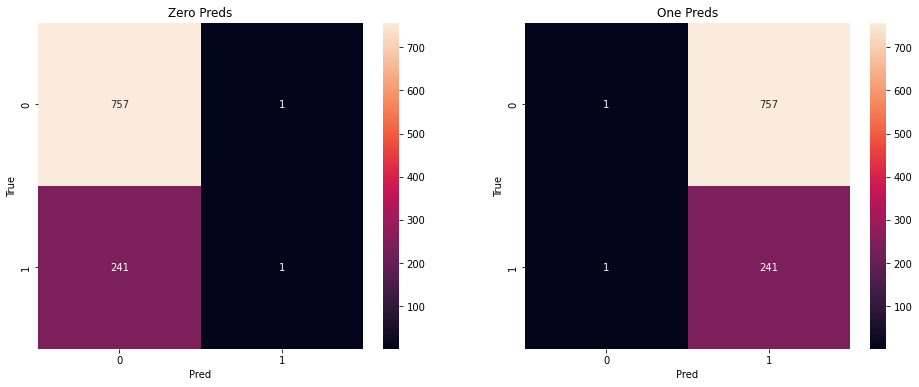

In [20]:
confusion_matrix_zero = confusion_matrix(y_true, y_pred_zero)
confusion_matrix_one = confusion_matrix(y_true, y_pred_one)

fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix_zero, annot=True, ax=axes[0], fmt="g")
sns.heatmap(confusion_matrix_one, annot=True, ax=axes[1], fmt="g")
axes[0].set_title("Zero Preds")
axes[0].set_xlabel("Pred")
axes[0].set_ylabel("True")
axes[1].set_title("One Preds");
axes[1].set_xlabel("Pred")
axes[1].set_ylabel("True");

In [21]:
f1_score_zero = fbeta_score(y_true, y_pred_zero, beta=1)
f2_score_zero = fbeta_score(y_true, y_pred_zero, beta=2)
recall_score_zero = recall_score(y_true, y_pred_zero)
precision_score_zero = precision_score(y_true, y_pred_zero)

f1_score_one = fbeta_score(y_true, y_pred_one, beta=1)
f2_score_one = fbeta_score(y_true, y_pred_one, beta=2)
recall_score_one = recall_score(y_true, y_pred_one)
precision_score_one = precision_score(y_true, y_pred_one)

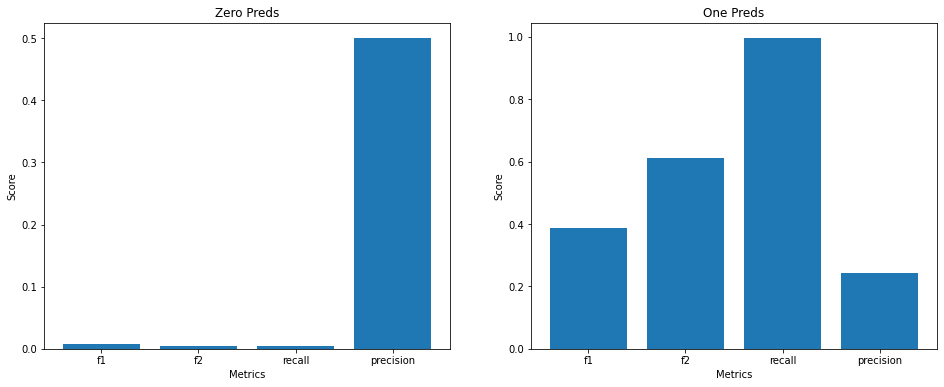

In [22]:
x_labels = ["f1", "f2", "recall", "precision"]
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].bar(x_labels, [f1_score_zero, f2_score_zero, recall_score_zero, precision_score_zero])
axes[1].bar(x_labels, [f1_score_one, f2_score_one, recall_score_one, precision_score_one])
axes[0].set_title("Zero Preds")
axes[0].set_xlabel("Metrics")
axes[0].set_ylabel("Score")
axes[1].set_title("One Preds");
axes[1].set_xlabel("Metrics")
axes[1].set_ylabel("Score");